# Doppler Shift

This recreates this example:

![example](../../paper/figures/rotation_doppler_outflow.png)

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from model import read_data, doppler_shift, filter_by_theta, filter_by_direction, get_spectra, plot_spectra

% matplotlib inline

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=30)

### Functions

In [9]:
def plot_redshift(vout, vrot, logtau):
    mint= 0
    maxt = 0.5
    
    data = read_data(vrot, vout, logtau)
    data_theta = filter_by_theta(data, mint, maxt)
    data_red, data_blue = filter_by_direction(data_theta)
    
    x, y = get_spectra(data_theta, as_hist=False)
    x_red, y_red = get_spectra(data_red, as_hist=False)
    x_blue, y_blue = get_spectra(data_blue, as_hist=False)
    
    fig, ax = plt.subplots(figsize=(14., 9.))
    
    plot_spectra(x, y, ax, lw=3, label='Full Spectra')
    plot_spectra(x_red, y_red, ax, lw=1, ls=':', c='k', label='Red')
    plot_spectra(x_blue, y_blue, ax, lw=1, ls='--', c='k', label='Blue')
    
    plt.legend(loc='upper left')
    plt.xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')
    plt.ylabel('$\mathrm{Intensity}$ ($\mathrm{Arbitrary}$ $\mathrm{Units}$)')
    plt.savefig('discussion/doppler.png')
    plt.show()

### Redshift

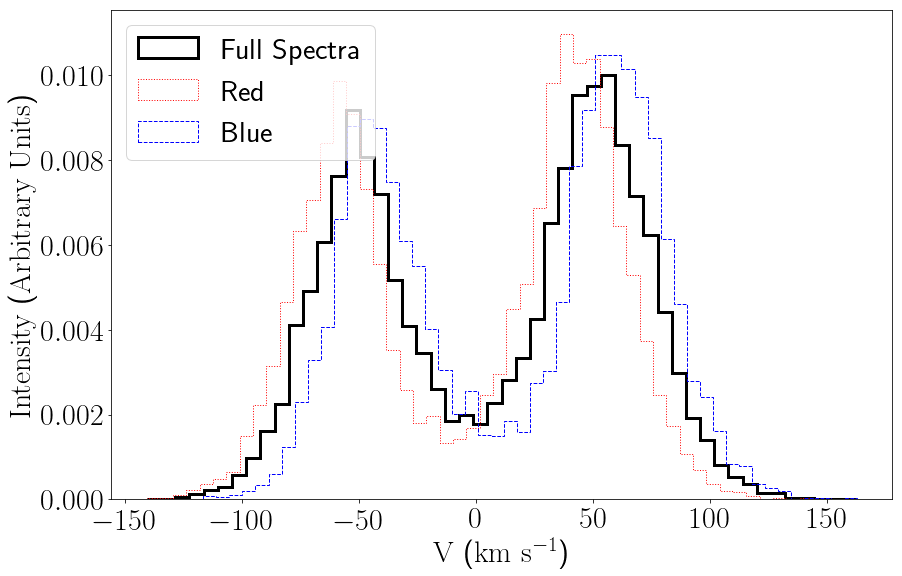

In [5]:
plot_redshift(vout=5, vrot=100, logtau=5)

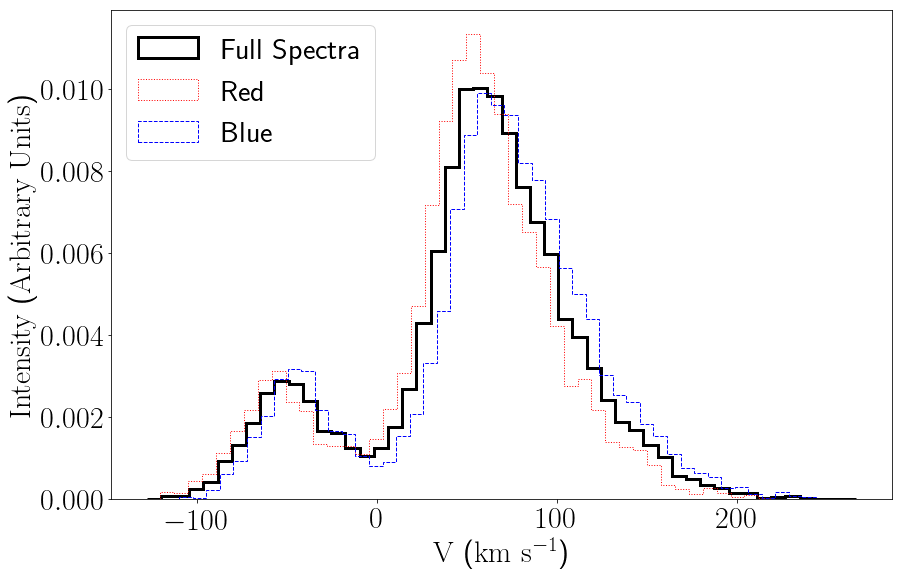

In [6]:
plot_redshift(vout=50, vrot=100, logtau=5)

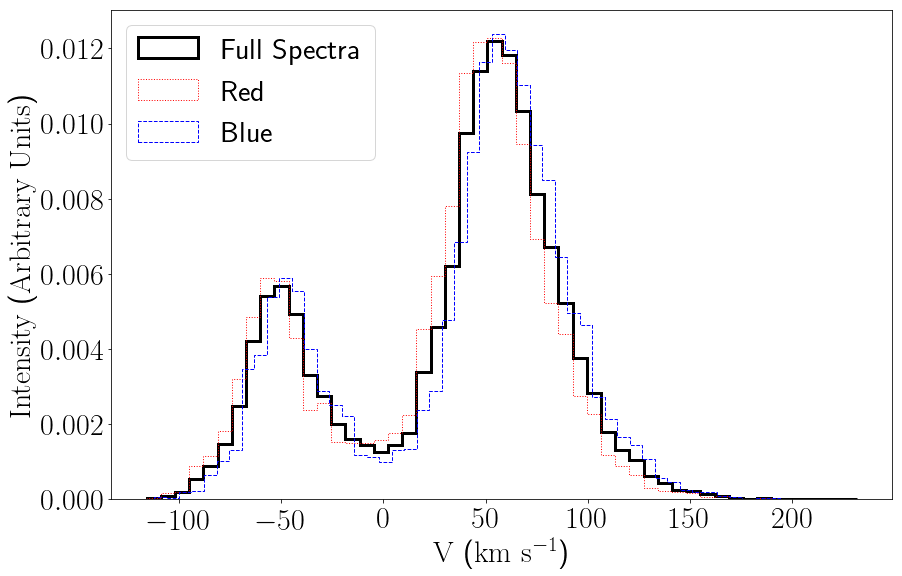

In [7]:
plot_redshift(vout=25, vrot=50, logtau=5)

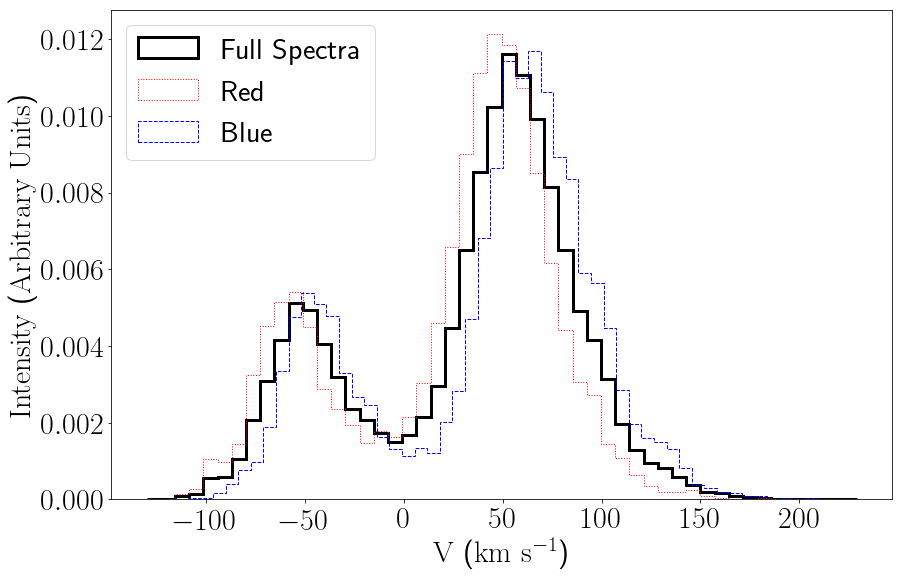

In [8]:
plot_redshift(vout=25, vrot=100, logtau=5)

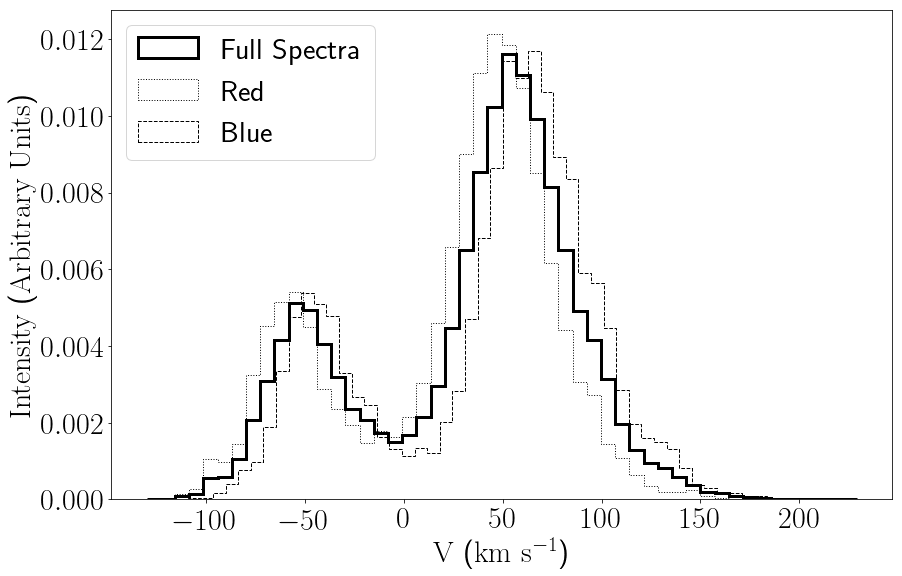

In [10]:
plot_redshift(vout=25, vrot=100, logtau=5)